In [ ]:
# Install needed libraries
print("Installing needed libraries...")
!pip install sacremoses clean-text nltk nlp spacy unidecode gender-guesser negate gensim protobuf sentencepiece seaborn scikit-learn nlpaug -q
!pip install -U git+https://github.com/makcedward/nlpaug.git -q
!pip install datasets -q
!pip install -U transformers -q
!pip install torch --upgrade -q
!pip install scipy==1.10.1 -q
!pip install -U accelerate -q
!pip install -U transformers -q
!pip install -U spacy-transformers -q
print("Installed")

In [5]:
import random
import torch
import json
import spacy
import numpy as np
import gc
import subprocess
import nltk

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import gender_guesser.detector as gender
from negate import Negator
from tqdm import tqdm
from datasets import load_dataset


class DataAugmentation:
    
    def __init__(self, dataset):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.dataset = dataset
        
        print("Loading models...")
        
        # Initialize negator model
        print("Loading negator model...")
        self.negator = Negator(fail_on_unsupported=True)
        
        # Initialize gender detector
        print("Loading gender detector model...")
        self.gd = gender.Detector()
                
        # Load synonym augmenter using words from WordNet
        print("Loading synonym augmenter...")
        self.aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.4)
        
        # Load random character deletion augmenter
        print("Loading random character deletion augmenter...")
        self.rand_rem = nac.RandomCharAug(action="delete")

        """ OTHER METHODS THAT TAKE TOO LONG
        # Load back translation augmenter
        self.back_translation_aug = naw.BackTranslationAug(
            from_model_name='Helsinki-NLP/opus-mt-en-de',
            to_model_name='Helsinki-NLP/opus-mt-de-en',
            device='cuda'
        )

        # Load abstractive summarization augmenter
        self.abstractive_aug = nas.AbstSummAug(model_path='t5-base', device = 'cuda')
        """

        

        print("Models loaded")

    """ OTHER METHODS THAT TAKE TOO LONG
    # Abstractive summarization augmentation
    def abstractive_summarization_augmenter(self, item):
        new_item = {}

        augmented_text_hypothesis = self.abstractive_aug.augment(item['hypothesis'])
        
        new_item['premise'] = item['premise']
        new_item['hypothesis'] = augmented_text_hypothesis[0]
        new_item['label'] = item['label']
        new_item['augmentation'] = 'abstractive_summarization_augmenter'

        return new_item

    
    # Back translate the hypothesis (from English to German and back to English)
    def back_translate(self, item):
        new_item = {}

        augmented_text_hypothesis = self.back_translation_aug.augment(item['hypothesis'])
        
        new_item['premise'] = item['premise']
        new_item['hypothesis'] = augmented_text_hypothesis[0]
        new_item['label'] = item['label']
        new_item['augmentation'] = 'back_translate'
        

        return new_item
    
    # Replace some words with their synonyms from WordNet using WSD from dataset
    def synonym_replacement(self, item):
        def get_generic_term(word, synset_name):
            if synset_name == 'O':  # Check for 'O' synset and ignore it
                return None
            try:
                synset = wn.synset(synset_name)
                lemmas = synset.lemmas()
                if not lemmas:
                    return None
                
                return lemmas[0].name()
            except Exception as e:
                #print(f"Error retrieving synset {synset_name}: {e}")
                return None
        
        new_item = {}
        wsd_data = item.get('wsd', {})
    
        premise_changed, hypothesis_changed = False, False
        
        new_premise = item['premise']
        new_hypothesis = item['hypothesis']
    
        for entry in wsd_data.get('premise', []):
            generic_term = get_generic_term(entry['text'], entry.get('nltkSynset'))
            
            if generic_term and generic_term != entry['text']:
                new_premise = new_premise.replace(entry['text'], generic_term)
                premise_changed = True
    
        for entry in wsd_data.get('hypothesis', []):
            generic_term = get_generic_term(entry['text'], entry.get('nltkSynset'))
                                            
            if generic_term and generic_term != entry['text']:
                new_hypothesis = new_hypothesis.replace(entry['text'], generic_term)
                hypothesis_changed = True
    
        if not premise_changed and not hypothesis_changed:
            return item
    
        new_item['premise'] = new_premise
        new_item['hypothesis'] = new_hypothesis
        new_item['label'] = item['label']
        new_item['augmentation'] = 'synonym_replacement'
        return new_item
    """


    # Repace some words in the premise with their synonyms using WordNet and library nlpaug
    def substitute_premise_words_using_wordnet(self, item):

        new_item = {}
        premise = item['premise']
        
        new_premise = self.aug.augment(premise)

        new_item['premise'] = new_premise[0]
        new_item['hypothesis'] = item['hypothesis']
        new_item['label'] = item['label']
        new_item['augmentation'] = 'substitute_premise_words_using_wordnet'
        return new_item
    
    def change_dates_in_hypothesis(self, item):
        def replace_temporal_expressions(doc):
            days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
            months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

            new_tokens = []
            replaced = False  # Flag to track if any replacement is done

            for token in doc:
                if token.ent_type_ == "DATE":
                    text = token.text
                    if text in days:
                        new_tokens.append(random.choice([d for d in days if d != text]))
                        replaced = True
                    elif text in months:
                        new_tokens.append(random.choice([m for m in months if m != text]))
                        replaced = True
                    elif text.isdigit() and (1 <= int(text) <= 31):
                        new_tokens.append(str(random.randint(1, 31)))
                        replaced = True
                    else:
                        new_tokens.append(token.text)
                else:
                    new_tokens.append(token.text)

            return new_tokens, replaced

        new_item = {}
        new_item['premise'] = item['premise']

        hypothesis = item['hypothesis']
        doc = nlp(hypothesis)
        new_hypothesis_tokens, replaced = replace_temporal_expressions(doc)

        if not replaced:
            return item

        new_hypothesis = " ".join(new_hypothesis_tokens)
        new_item['hypothesis'] = new_hypothesis

        # Change the label accordingly if needed
        if item['label'] == "ENTAILMENT":
            new_item['label'] = "CONTRADICTION"
        elif item['label'] == "CONTRADICTION":
            new_item['label'] = "CONTRADICTION"
        elif item['label'] == "NEUTRAL":
            new_item['label'] = "NEUTRAL"

        new_item['augmentation'] = 'change_dates_in_hypothesis'
        return new_item
    
    # Replace names found using NER in the hypothesis with random names
    def replace_names_in_hypothesis(self, item):
        def replace_person_names(tokens):
            random_names = random_names = [
                "John Doe", "Jane Smith", "Alice Johnson", "Bob Brown", "Charlie Davis",
                "Daniel Wilson", "Emily Clark", "Frank Thomas", "Grace Lewis", "Hannah Walker",
                "Isaac Young", "Jessica Hall", "Kevin Allen", "Laura Scott", "Matthew King",
                "Nathan Wright", "Olivia Baker", "Patrick Harris", "Quinn Morgan", "Rachel Cooper",
                "Steven Edwards", "Tina Mitchell", "Ulysses Martinez", "Victoria Roberts", "William Phillips",
                "Xander Turner", "Yvonne Parker", "Zachary Stewart", "Amber Hughes", "Brian Green",
                "Catherine Adams", "David Nelson", "Erica Carter", "Fiona White", "George Thompson",
                "Helen Perez", "Ian Collins", "Julia Ramirez", "Kyle Rogers", "Lily Reed",
                "Michael Campbell", "Nina Simmons", "Oscar Gray", "Paula Butler", "Quincy Foster",
                "Rebecca Gonzalez", "Samuel Henderson", "Teresa Bryant", "Umar Ramirez", "Vanessa Fisher",
                "Walter Mills", "Xena Ford", "Yusuf Kelly", "Zoey Graham", "Aaron Barnes",
                "Brenda Jenkins", "Caleb Wood", "Diana Hunt", "Ethan Palmer", "Faith Black"
            ]

    
            new_tokens = []
            for token in tokens:
                if token.ent_type_ == 'PERSON':
                    new_tokens.append(random.choice(random_names))
                else:
                    new_tokens.append(token.text)
            return new_tokens
    
        new_item = {}
        new_item['premise'] = item['premise']
    
        doc = nlp(item['hypothesis'])
        new_hypothesis_tokens = replace_person_names(doc)
    
        new_hypothesis = " ".join(new_hypothesis_tokens)
        new_item['hypothesis'] = new_hypothesis
    
        # Change the label accordingly if needed
        if item['label'] == "ENTAILMENT":
            new_item['label'] = "CONTRADICTION"
        elif item['label'] == "CONTRADICTION":
            return item
        elif item['label'] == "NEUTRAL":
            new_item['label'] = "NEUTRAL"
    
        new_item['augmentation'] = 'replace_names_in_hypothesis'
        return new_item



    # Infer the gender of the first person mentioned in the premise using NER and replace the hypothesis accordingly
    def gender_guesser(self, item):
        def get_names_genders(sentence):
            doc = nlp(sentence)
            proper_names = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ == 'PERSON']
            genders = {name: self.gd.get_gender(name.split()[0]) for name, label in proper_names}
            return proper_names, genders
        
        new_item = {}
        new_item['premise'] = item['premise']
        new_item['hypothesis'] = item['hypothesis']
        new_item['label'] = item['label']
        
        proper_names, genders = get_names_genders(item['premise'])     
        
        if len(genders) > 0:
            if genders[proper_names[0][0]] in ('male', 'female'):
                if random.random() > 0.5:
                    new_item['hypothesis'] = f"{proper_names[0][0]} is a {genders[proper_names[0][0]]}"
                    new_item['label'] = "ENTAILMENT"
                else:
                    new_item['hypothesis'] = f"{proper_names[0][0]} is not a {genders[proper_names[0][0]]}"
                    new_item['label'] = "CONTRADICTION"
        
        new_item['augmentation'] = 'gender_guesser'
        return new_item


    # shuffle the order of sentences in the hypothesis
    def shuffle_sentence_order(self, item):
        new_item = {}
        new_item['premise'] = item['premise']
        
        # Shuffle the order of sentences in the hypothesis
        hypothesis = item['hypothesis']
        sentences = hypothesis.split('. ')
        if len(sentences) > 1:
            random.shuffle(sentences)
            new_hypothesis = '. '.join(sentences)
        else:
            new_hypothesis = hypothesis
        
        new_item['hypothesis'] = new_hypothesis
        new_item['label'] = item['label']
        new_item['augmentation'] = 'shuffle_sentence_order'
        return new_item

    # Remove random characters from the premise to increase noise robustness
    def remove_random_characters(self, item):
        new_item = {}
        
        premise = item['premise']
        augmented_text = self.rand_rem.augment(premise)
        
        new_item['premise'] = augmented_text[0]
        new_item['hypothesis'] = item['hypothesis']
        new_item['label'] = item['label']
        return new_item


    # Insert random phrases in the premise and hypothesis to increase noise robustness and avoid overfitting
    def random_phrase_insertion(self, item):
        def insert_random_phrase(text, phrases, insert_prob=0.3):
            sentences = text.split('. ')
            new_sentences = []
            
            for sentence in sentences:
                new_sentences.append(sentence)
                if random.random() < insert_prob:
                    random_phrase = random.choice(phrases)
                    new_sentences.append(random_phrase)
            
            return '. '.join(new_sentences)
        
        random_phrases = [
            "In addition,", "Moreover,", "Interestingly,", "As a matter of fact,", "Consequently,",
            "Surprisingly,","Nevertheless,", "Furthermore,", "On the other hand,", "For example,",
            "In contrast,", "As such,", "To illustrate,", "For instance,", "On the contrary,",
            "In other words,", "As a result,", "Thus,", "Hence,"
        ]
        
        new_item = {}
        new_item['premise'] = insert_random_phrase(item['premise'], random_phrases)
        new_item['hypothesis'] = insert_random_phrase(item['hypothesis'], random_phrases)
        new_item['label'] = item['label']
        new_item['augmentation'] = 'random_phrase_insertion'
        return new_item

    # Remove random words from the premise (10%) to increase noise robustness
    def random_words_remover(self, item):
        def remove_random_words(text, remove_prob=0.1):
            words = text.split()
            new_words = [word for word in words if random.random() > remove_prob]
            return ' '.join(new_words)
        
        new_item = {}
        new_item['premise'] = remove_random_words(item['premise'])
        new_item['hypothesis'] = item['hypothesis']
        new_item['label'] = item['label']
        new_item['augmentation'] = 'random_words_remover'
        return new_item


    # Negate the hypothesis and change the label accordingly
    def negate_sentence(self, item):
        new_item = {}
        new_item['premise'] = item['premise']
        
        try:
            new_item['hypothesis'] = self.negator.negate_sentence(item['hypothesis'])
        except RuntimeError:
            return item
        
        if item['label'] == "ENTAILMENT":
            new_item['label'] = "CONTRADICTION"
        elif item['label'] == "CONTRADICTION":
            new_item['label'] = "ENTAILMENT"
        elif item['label'] == "NEUTRAL":
            new_item['label'] = "NEUTRAL"
        
        new_item['augmentation'] = 'negate_sentence'
        return new_item

    
    def create_augmented_samples(self, item, single_random = True):
        # Augmentation methods dictionary
        augmentations = {
            
            # Methods that change the meaning of the samples or infer new information
            'negate_sentence': self.negate_sentence,                                                       #works
            'gender_guesser': self.gender_guesser,                                                         #works
            'replace_names_in_hypothesis': self.replace_names_in_hypothesis,                               #works
            'change_dates_in_hypothesis': self.change_dates_in_hypothesis,                                 #works
            
            # Methods that modify the samples or add noise but do not change the meaning
            'substitute_premise_words_using_wordnet': self.substitute_premise_words_using_wordnet,         #works
            'shuffle_sentence_order': self.shuffle_sentence_order,                                         #works
            'random_phrase_insertion': self.random_phrase_insertion,                                       #works
            'remove_random_characters': self.remove_random_characters,                                     #works
            'random_words_remover': self.random_words_remover, #70%                                        #works
            
            #'synonym_replacement': self.synonym_replacement,                                              #works but duplicate
            #'back_translate': self.back_translate,                                                        #takes too long
            #'abstractive_summarization_augmenter': self.abstractive_summarization_augmenter,              #takes too long
        }

        if (single_random == True):
            # Select a random augmentation method
            selected_augmentations = random.sample(list(augmentations.values()), 1)
        
            # Apply the selected augmentation methods
            augmented_item = selected_augmentations[0](item)

            return [augmented_item] if augmented_item else []
        else:
            # Add each sample augmented with each method
            augmented_samples = []
            for name, method in augmentations.items():
                augmented_sample = method(item)
                #if augmented_sample:
                #    augmented_samples.append(augmented_sample)
            
            return augmented_samples


    def augment_and_save_dataset(self, file_path, target_count):
        augmented_data = []

        print(f"Creating a dataset with {target_count} samples...")
        
        # Augment data
        while len(augmented_data) < target_count:
            for item in tqdm(self.dataset):
                augmented_samples = self.create_augmented_samples(item)
                for augmented_sample in augmented_samples:
                    if augmented_sample['premise'] != item['premise'] or augmented_sample['hypothesis'] != item['hypothesis']:
                        augmented_data.append(augmented_sample)
                        
                        # Check if target count is reached
                        if len(augmented_data) >= target_count:
                            break
                # Check if target count is reached
                if len(augmented_data) >= target_count:
                    break

        
        # Save augmented data
        with open(file_path, 'w', encoding="utf-8") as f:
            for sample in augmented_data:
                json.dump(sample, f, ensure_ascii=False)
                f.write('\n')

    
    def augment_and_save_dataset_eq(self, file_path, target_count, val = False):
        if val == True:
            label_counts = {"CONTRADICTION": 775, "ENTAILMENT": 821, "NEUTRAL": 692}
        else:
            label_counts = {"CONTRADICTION": 12331, "ENTAILMENT": 31128, "NEUTRAL": 7627}
        
        augmented_data = []

        print(f"Creating a dataset with {target_count} samples for each label...")
        

        print("CONTRADICTION:", label_counts["CONTRADICTION"], " so i will add", target_count - label_counts["CONTRADICTION"], "samples")
        print("ENTAILMENT:", label_counts["ENTAILMENT"], " so i will add", target_count - label_counts["ENTAILMENT"], "samples")
        print("NEUTRAL:", label_counts["NEUTRAL"], " so i will add", target_count - label_counts["NEUTRAL"], "samples")
    
        # Augment data
        while (label_counts["ENTAILMENT"] < target_count or label_counts["CONTRADICTION"] < target_count or label_counts["NEUTRAL"] < target_count):
            for item in tqdm(self.dataset):
                augmented_samples = self.create_augmented_samples(item)
                for augmented_sample in augmented_samples:
                    if label_counts[augmented_sample['label']] < target_count:

                        if augmented_sample['premise'] != item['premise'] or augmented_sample['hypothesis'] != item['hypothesis']:
                            augmented_data.append(augmented_sample)
                            label_counts[augmented_sample['label']] += 1

                            
                if label_counts["ENTAILMENT"] >= target_count and label_counts["CONTRADICTION"] >= target_count and label_counts["NEUTRAL"] >= target_count:
                    break
        
        # Save augmented data
        with open(file_path, 'w', encoding="utf-8") as f:
            for sample in augmented_data:
                json.dump(sample, f, ensure_ascii=False)
                f.write('\n')



def main():
    print("Loading dataset...")
    dataset = load_dataset("tommasobonomo/sem_augmented_fever_nli").shuffle(seed=42)
    
    print("Creating data augmentor...")
    augmentor = DataAugmentation(dataset['train'])
    
    print("Augmenting and saving dataset...")
    augmentor.augment_and_save_dataset_eq("augmented_train_data.jsonl", 35000)
    print("\nAugmented data saved as 'augmented_train_data.jsonl'")
    
    print("Augmenting and saving val-set...")
    augmentor = DataAugmentation(dataset['validation'])
    augmentor.augment_and_save_dataset_eq("augmented_val_data.jsonl", 2000, val = True)
    print("\nAugmented data saved as 'augmented_val_data.jsonl'")



if __name__ == "__main__":
    
    print("DATA AUGMENTATION FOR NLI TASK - FRASCA EMANUELE 1836098\n")
    print("Setting up the environment...")
    
    # Set random seeds for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)

    gc.enable()

    # Load the spaCy model and nltk wordnet corpus
    try:
        nlp = spacy.load("en_core_web_sm")
    except IOError:
        subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    
    nlp = spacy.load("en_core_web_sm")
    
    nltk.download('wordnet')
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    print("Setting up finished\n")
    main()

DATA AUGMENTATION FOR NLI TASK - FRASCA EMANUELE 1836098

Setting up the environment...


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andrea\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using device: cuda
Setting up finished

Loading dataset...
Creating data augmentor...
Loading models...
Loading negator model...
Loading gender detector model...
Loading synonym augmenter...
Loading random character deletion augmenter...
Models loaded
Augmenting and saving dataset...
Creating a dataset with 35000 samples for each label...
CONTRADICTION: 12331  so i will add 22669 samples
ENTAILMENT: 31128  so i will add 3872 samples
NEUTRAL: 7627  so i will add 27373 samples


 71%|█████████████████████████████████████████████████████▎                     | 36354/51086 [02:59<01:12, 202.85it/s]



Augmented data saved as 'augmented_train_data.jsonl'
Augmenting and saving val-set...
Loading models...
Loading negator model...
Loading gender detector model...
Loading synonym augmenter...
Loading random character deletion augmenter...
Models loaded
Creating a dataset with 2000 samples for each label...
CONTRADICTION: 775  so i will add 1225 samples
ENTAILMENT: 821  so i will add 1179 samples
NEUTRAL: 692  so i will add 1308 samples


 98%|███████████████████████████████████████████████████████████████████████████▏ | 2234/2288 [00:10<00:00, 208.41it/s]



Augmented data saved as 'augmented_val_data.jsonl'


MODEL TRAINING AND TESTING ENVIRONMENT FOR NLI TASK - FRASCA EMANUELE 1836098

Setting up the environment...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using device: cuda
Setting up finished


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL TEST-SET
Computing baselines on the original test-set...


100%|██████████| 18/18 [00:02<00:00,  6.50it/s]


Random baseline -> Accuracy:  0.3296895496283341 , Precision:  0.33068094973782347 , Recall:  0.3296895496283341 , F1-score:  0.3300988495722251
Majority class baseline -> Accuracy:  0.35505028421512896 , Precision:  0.12606070432124386 , Recall:  0.35505028421512896 , F1-score:  0.1860605555228685
ADVERSARIAL TEST-SET
Computing baselines on the adversarial test-set...


100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


Random baseline -> Accuracy:  0.3115727002967359 , Precision:  0.3117316498910626 , Recall:  0.3115727002967359 , F1-score:  0.3116229965073771
Majority class baseline -> Accuracy:  0.34421364985163205 , Precision:  0.11848303674418195 , Recall:  0.34421364985163205 , F1-score:  0.17628601935006322


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading roberta model trained on the original dataset...
ORIGINAL TEST-SET
Testing the model on the original test-set...


100%|██████████| 18/18 [00:03<00:00,  4.84it/s]


[[711  48  33]
 [152 368 163]
 [ 76 112 624]]


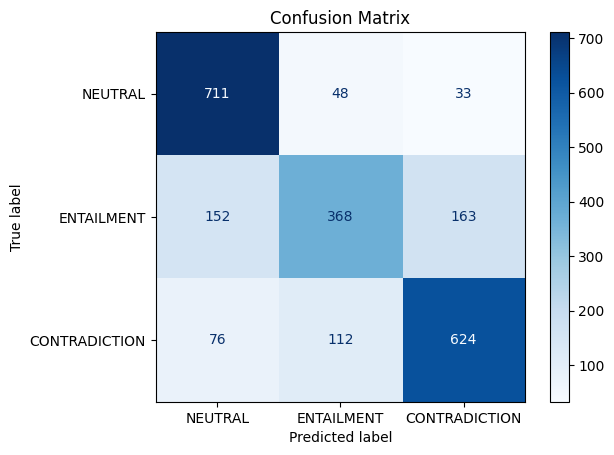

Test Loss: 1.0939884583155315, Test Accuracy: 0.7446436379536511, Precision: 0.7405490987700387, Recall: 0.7446436379536511, F1-score: 0.7375003043412567

ADVERSARIAL TEST-SET
Testing the model on the adversarial test-set...


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


[[57 20 34]
 [27 60 23]
 [30 22 64]]


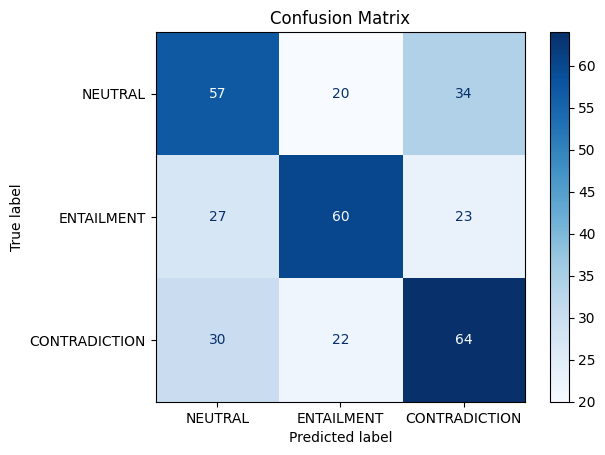

Test Loss: 1.491355170806249, Test Accuracy: 0.5370919881305638, Precision: 0.538757431020082, Recall: 0.5370919881305638, F1-score: 0.537548783302469


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading roberta model trained on the augmented dataset...
ORIGINAL TEST-SET
Testing the model on the original test-set...


100%|██████████| 18/18 [00:03<00:00,  4.94it/s]


[[719  38  35]
 [178 345 160]
 [ 88 119 605]]


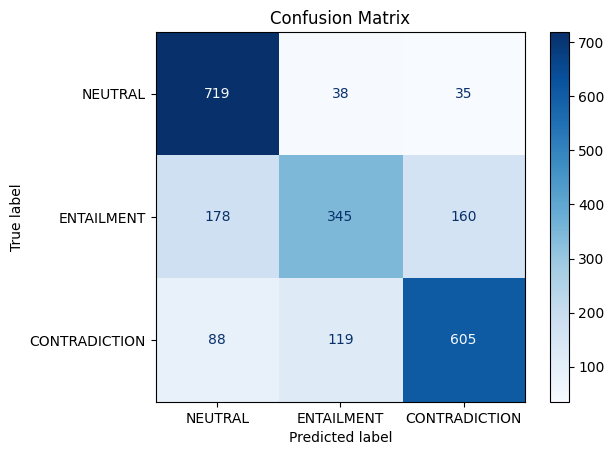

Test Loss: 1.3372829291555617, Test Accuracy: 0.729777000437254, Precision: 0.7265357355632702, Recall: 0.729777000437254, F1-score: 0.7206424671961422

ADVERSARIAL TEST-SET
Testing the model on the adversarial test-set...


100%|██████████| 6/6 [00:01<00:00,  5.00it/s]


[[65 15 31]
 [42 53 15]
 [41  8 67]]


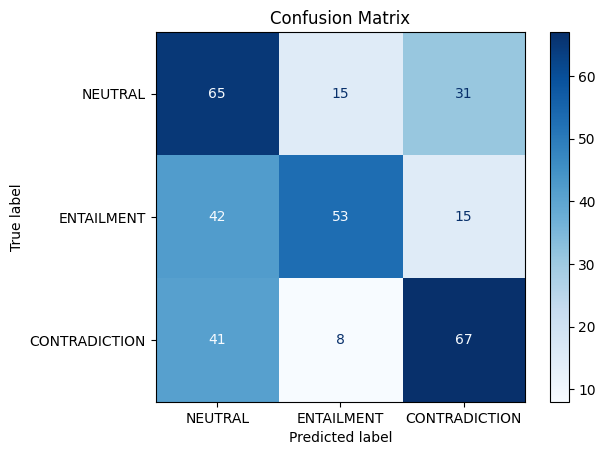

Test Loss: 2.0419154266516366, Test Accuracy: 0.5489614243323442, Precision: 0.5763777073523335, Recall: 0.5489614243323442, F1-score: 0.552760198857384


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading roberta_df model trained on the original dataset...
ORIGINAL TEST-SET
Testing the model on the original test-set...


100%|██████████| 18/18 [00:03<00:00,  4.87it/s]


[[647 121  24]
 [ 97 489  97]
 [ 55 231 526]]


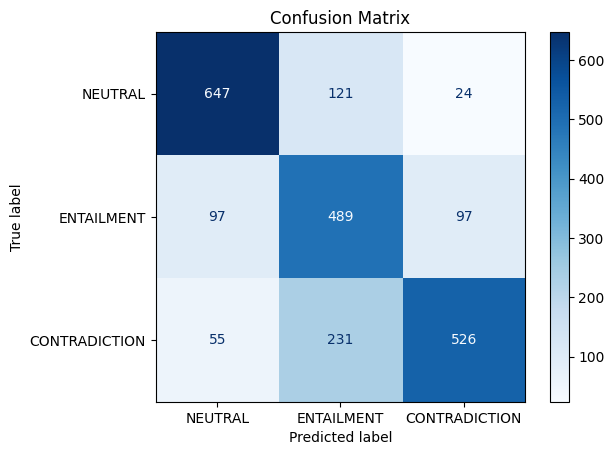

Test Loss: 0.7883727732631896, Test Accuracy: 0.7267162221250547, Precision: 0.7427217560106396, Recall: 0.7267162221250547, F1-score: 0.7293145874733794

ADVERSARIAL TEST-SET
Testing the model on the adversarial test-set...


100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


[[40 39 32]
 [11 91  8]
 [13 50 53]]


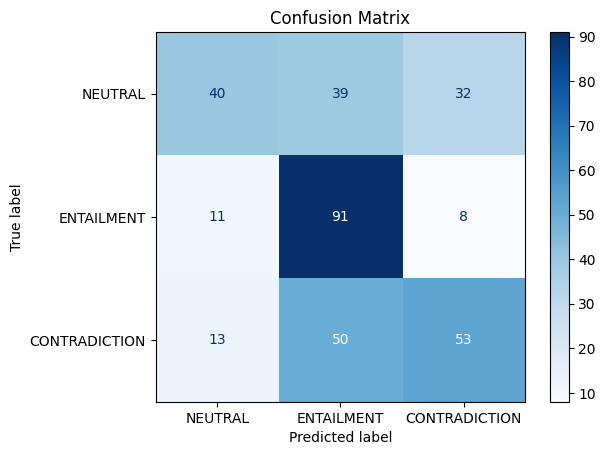

Test Loss: 1.0517771939436595, Test Accuracy: 0.5459940652818991, Precision: 0.567043436180509, Recall: 0.5459940652818991, F1-score: 0.5299996314143777


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading roberta_df model trained on the augmented dataset...
ORIGINAL TEST-SET
Testing the model on the original test-set...


100%|██████████| 18/18 [00:03<00:00,  5.00it/s]


[[731  34  27]
 [199 342 142]
 [104 124 584]]


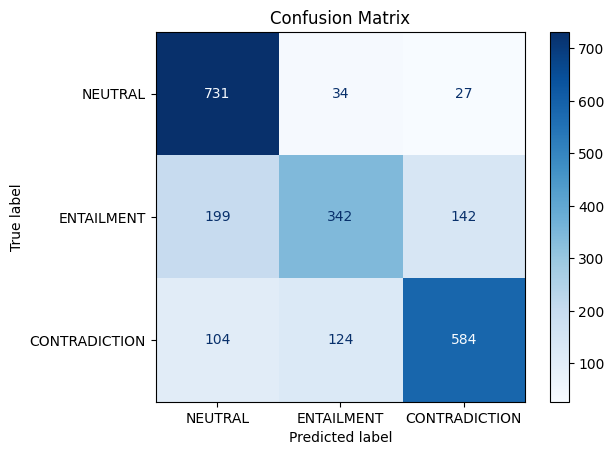

Test Loss: 0.9637270735369788, Test Accuracy: 0.724529951902055, Precision: 0.724462262243036, Recall: 0.724529951902055, F1-score: 0.7149285419682948

ADVERSARIAL TEST-SET
Testing the model on the adversarial test-set...


100%|██████████| 6/6 [00:01<00:00,  4.62it/s]


[[63 17 31]
 [39 62  9]
 [38 17 61]]


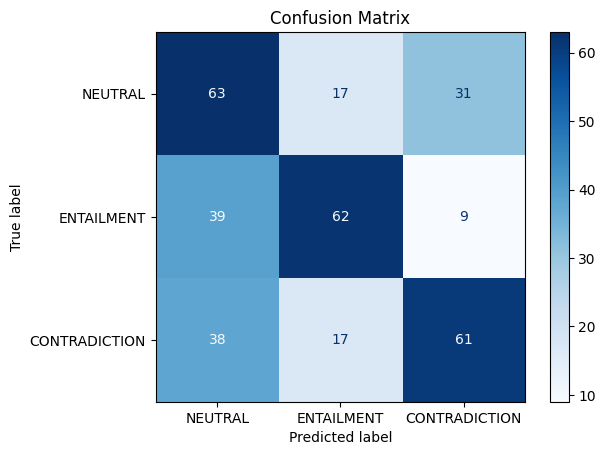

Test Loss: 1.356003036101659, Test Accuracy: 0.5519287833827893, Precision: 0.5669171293983998, Recall: 0.5519287833827893, F1-score: 0.555345096832669
Loading deberta model trained on the original dataset...
ORIGINAL TEST-SET
Testing the model on the original test-set...


100%|██████████| 18/18 [00:10<00:00,  1.64it/s]


[[666 100  26]
 [ 96 471 116]
 [ 20 173 619]]


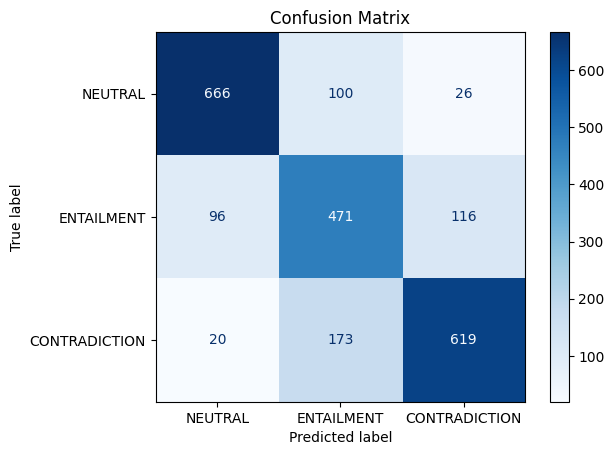

Test Loss: 0.6536495917373233, Test Accuracy: 0.7678181023174464, Precision: 0.7727954800181308, Recall: 0.7678181023174464, F1-score: 0.7696400109539207

ADVERSARIAL TEST-SET
Testing the model on the adversarial test-set...


100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

[[50 30 31]
 [ 3 96 11]
 [ 6 31 79]]


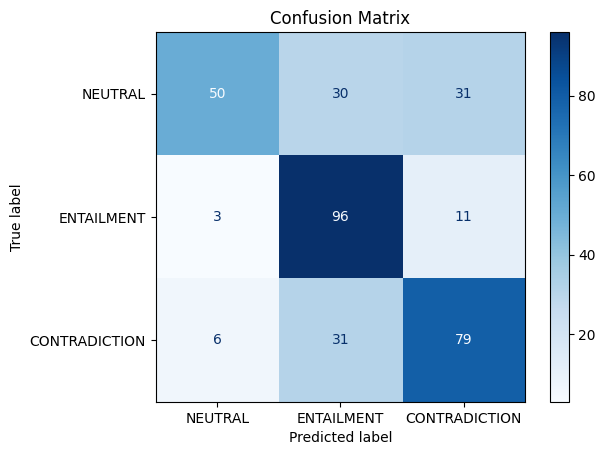

Test Loss: 0.7331701964139938, Test Accuracy: 0.6676557863501483, Precision: 0.703455431148568, Recall: 0.6676557863501483, F1-score: 0.6579482925100824
Loading deberta model trained on the augmented dataset...
ORIGINAL TEST-SET
Testing the model on the original test-set...


100%|██████████| 18/18 [00:10<00:00,  1.65it/s]

[[710  57  25]
 [124 413 146]
 [ 33 144 635]]


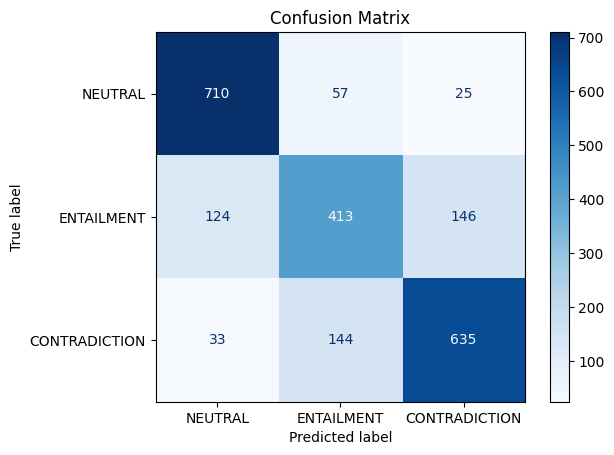

Test Loss: 0.7287175224887, Test Accuracy: 0.7686926104066463, Precision: 0.764197819913668, Recall: 0.7686926104066463, F1-score: 0.7652945266307689

ADVERSARIAL TEST-SET
Testing the model on the adversarial test-set...


100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

[[55 16 40]
 [13 85 12]
 [ 9 17 90]]


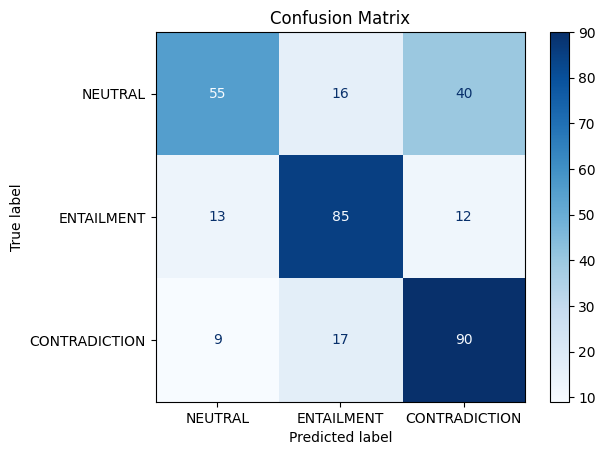

Test Loss: 0.998171811302503, Test Accuracy: 0.6824925816023739, Precision: 0.6885582468304775, Recall: 0.6824925816023739, F1-score: 0.6762450591347982


In [10]:
import argparse
import os
import torch
import random
import spacy
import nltk
import seaborn as sns
import gc
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import subprocess
from datasets import concatenate_datasets
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm
from cleantext import clean
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import wordnet as wn
from nltk.tree import Tree
from torch.utils.data import Dataset
from datasets import load_dataset
from transformers import (
    RobertaTokenizer,
    RobertaModel,
    AutoTokenizer,
    AutoModel,
    RobertaConfig
)
from torch.cuda.amp import GradScaler, autocast


os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings('ignore')



class FeverDataset(Dataset):
    def __init__(self, dataset, tokenizer):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.labels = {
            "ENTAILMENT": 0,
            "NEUTRAL": 1,
            "CONTRADICTION": 2
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        
        premise = item["premise"].encode('ascii', errors='ignore').decode()
        hypothesis = item["hypothesis"].encode('ascii', errors='ignore').decode()
        
        premise = clean(premise, lower=True)
        hypothesis = clean(hypothesis, lower=True)
        label = item["label"]
        
        # Format the input
        input = f"[CLS] {premise} [SEP] {hypothesis}"
        
        input_ids = self.tokenizer.encode(input, add_special_tokens=False, max_length=512, truncation=True)
        label = self.labels[label] # Convert the label to a number

        return torch.tensor(input_ids), torch.tensor(label)

def collate_fn(batch):
    input_ids = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Pad the input_ids
    input_ids = nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_mask = (input_ids != 0).float()
    return input_ids, torch.stack(labels), attention_mask

class NLIBaselines():
    def __init__(self, dataloader):
        self.dataloader = dataloader
    
    def random(self):
        all_labels = []
        all_predictions = []
        
        for batch in tqdm(self.dataloader):
            labels = batch[1].to(device)
            predictions = torch.randint(0, 3, (len(labels),)).to(device) # Create a tensor of random integers [0,2]
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
        
        return accuracy, precision, recall, f1
    
    def majority_class(self):
        label_counts = {0:0, 1:0, 2:0}
        
        # Find the most frequent class
        for batch in tqdm(self.dataloader):
            labels = batch[1].to(device)
            for label in labels:
                label = label.item()
                label_counts[label] += 1

        majority_class_label = max(label_counts, key=label_counts.get)
        
        all_labels = []
        all_predictions = []

        for batch in tqdm(self.dataloader):
            labels = batch[1].to(device)
            predictions = torch.full_like(labels, majority_class_label) # Create a tensor containing only the most frequent class
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
                
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
        
        return accuracy, precision, recall, f1


class TransformerModel(nn.Module):
    def __init__(self, model_name, dropout_rate=0.1):
        super(TransformerModel, self).__init__()
        self.transformer = model_name
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, 3)

    def forward(self, input_ids, attention_mask=None):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        cls_output = last_hidden_state[:, 0]
        #cls_output = self.dropout(cls_output) TO USE?
        logits = self.classifier(cls_output)
        return logits

class TransformerModelDropout(nn.Module):
    def __init__(self, model_name, dropout_rate=0.1):
        super(TransformerModelDropout, self).__init__()
        self.transformer = model_name
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, 3)

    def forward(self, input_ids, attention_mask=None):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        cls_output = last_hidden_state[:, 0]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits


class Trainer:
    def __init__(self, model, train_loader, val_loader, test_loader, num_epochs, criterion, optimizer, patience=5):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.num_epochs = num_epochs
        self.criterion = criterion
        self.optimizer = optimizer

        self.validation_losses = []
        self.validation_accuracies = []
        self.validation_precisions = []
        self.validation_recalls = []
        self.validation_f1s = []
        self.train_losses = []

        self.patience = patience
        self.early_stop = False
        self.best_val_loss = np.Inf
        self.counter = 0
        self.best_model_state = None
        self.current_epoch = -1
        self.best_epoch = -1
        self.best_val_acc = -1

        # Initialize GradScaler for mixed precision training
        self.scaler = GradScaler()

    def train(self):
        torch.cuda.empty_cache()
        gc.collect()

        for epoch in range(self.num_epochs):
            print(f"\nTraining epoch {epoch + 1}")

            self.current_epoch += 1
            if self.early_stop:
                print("Early stopping triggered")
                break

            self.model.train()
            running_loss = 0.0

            for batch in tqdm(self.train_loader):
                input_ids = batch[0].to(device)
                labels = batch[1].to(device)
                attention_mask = batch[2].to(device)

                self.optimizer.zero_grad()

                with autocast():
                    logits = self.model(input_ids, attention_mask)
                    loss = self.criterion(logits, labels)

                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()

                running_loss += loss.item() * input_ids.size(0)

            epoch_loss = running_loss / len(self.train_loader.dataset)
            self.train_losses.append(epoch_loss)

            # Compute validation metrics at the end of each epoch
            val_loss, val_acc, val_precision, val_recall, val_f1 = self.evaluate(self.val_loader)

            self.validation_losses.append(val_loss)
            self.validation_accuracies.append(val_acc)
            self.validation_precisions.append(val_precision)
            self.validation_recalls.append(val_recall)
            self.validation_f1s.append(val_f1)

            # Check for early stopping
            self.check_early_stopping(val_acc)

            print(f"Epoch: {epoch + 1}, Best Validation Accuracy so far: {self.best_val_acc}\nValidation Loss: {val_loss}, Train Loss: {epoch_loss}, Validation Accuracy: {val_acc}, Precision: {val_precision}, Recall: {val_recall}, F1-score: {val_f1}")

    def check_early_stopping(self, val_acc):
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.counter = 0

            self.best_epoch = self.current_epoch
            self.best_model_state = self.model.state_dict()
        else:
            self.counter += 1
            print(f"Model has not improved for {self.counter} epochs")
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"Early stopping after {self.counter} epochs without improvement")

    def evaluate(self, data_loader, print_output=False):
        self.model.eval()
        total_loss = 0
        total = 0
        correct = 0
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            for batch in tqdm(data_loader):
                input_ids = batch[0].to(device)
                labels = batch[1].to(device)
                attention_mask = batch[2].to(device)
        
                with autocast():
                    logits = self.model(input_ids, attention_mask)
                    loss = self.criterion(logits, labels)
        
                total_loss += loss.item()
                total += labels.size(0)
                correct += (logits.argmax(1) == labels).sum().item()
        
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(logits.argmax(1).cpu().numpy())
        
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        
        if print_output:
            self.plot_confusion_matrix(all_labels, all_preds)
        
        return total_loss / len(data_loader), accuracy, precision, recall, f1


    def test(self):
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
            print("Loaded best model from early stopping.")
    
        test_loss, test_acc, test_precision, test_recall, test_f1 = self.evaluate(self.test_loader, print_output=True)
        print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}, Precision: {test_precision}, Recall: {test_recall}, F1-score: {test_f1}")
        return test_loss, test_acc, test_precision, test_recall, test_f1
    
    

    def plot_confusion_matrix(self, labels, preds):
        cm = confusion_matrix(labels, preds)
        print(cm)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEUTRAL", "ENTAILMENT", "CONTRADICTION"])
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    def plot(self):
        plt.figure(figsize=(15, 10))

        best_epoch = self.best_epoch
        best_val_loss = self.validation_losses[best_epoch]

        plt.subplot(2, 2, 1)
        plt.plot(self.validation_losses, label="Validation Loss")
        plt.plot(self.train_losses, label="Train Loss")
        plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
        plt.axhline(y=best_val_loss, color='r', linestyle='--')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Losses")

        plt.subplot(2, 2, 2)
        plt.plot(self.validation_accuracies, label="Validation Accuracy")
        plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Validation Accuracy")

        plt.subplot(2, 2, 3)
        plt.plot(self.validation_precisions, label="Validation Precision")
        plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
        plt.xlabel("Epoch")
        plt.ylabel("Precision")
        plt.legend()
        plt.title("Validation Precision")

        plt.subplot(2, 2, 4)
        plt.plot(self.validation_recalls, label="Validation Recall")
        plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
        plt.xlabel("Epoch")
        plt.ylabel("Recall")
        plt.legend()
        plt.title("Validation Recall")

        plt.show()
        


def freeze_layers(model, num_layers_to_freeze):
    if isinstance(model, nn.DataParallel):
        model = model.module
    for name, param in model.transformer.named_parameters():
        layer_num = int(name.split('.')[2]) if 'layer' in name else -1
        if layer_num >= 0 and layer_num < num_layers_to_freeze:
            param.requires_grad = False

#################
# MAIN FUNCTION #
#################

def main(args):
    parser = argparse.ArgumentParser()
    parser.add_argument("action", choices=["train", "test", "baselines"], help="Action to perform: train, test or baselines")
    parser.add_argument("--data", choices=["original", "adversarial"], required=False, help="Dataset type: original or adversarial")
    parser.add_argument("--model", choices=["roberta", "roberta_df", "deberta"], required=False, help="Model type: roberta, roberta_df or deberta")
    args = parser.parse_args(args)
    
    gc.collect()

    if args.model == None:
        args.model = "roberta"

    if args.model == "roberta" or args.model == "roberta_df":
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        config = RobertaConfig.from_pretrained('roberta-base')
        model = RobertaModel.from_pretrained('roberta-base', config=config)
    
    elif args.model == "deberta":
        model = AutoModel.from_pretrained("microsoft/deberta-v3-large")
        tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
    
    else:
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        
    
    
    # DATASET AND DATALOADER CREATION
    
    # Load the complete original dataset
    original_dataset = load_dataset("tommasobonomo/sem_augmented_fever_nli").shuffle(seed=42)
    
    if args.data == "original":
        train_dataset = FeverDataset(original_dataset["train"], tokenizer)
        val_dataset = FeverDataset(original_dataset["validation"], tokenizer)

        # Class labels frequencies
        class_labels = np.array([0, 1, 2])  # 0: ENTAILMENT, 1: NEUTRAL, 2: CONTRADICTION
        y_train = np.concatenate([
            np.full(31128, 0),     # ENTAILMENT
            np.full(7627, 1),      # NEUTRAL
            np.full(12331, 2)      # CONTRADICTION
        ])
        
        # Calculate class weights because we have unbalanced dataset
        class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    
    elif args.data == "adversarial":
        # Load the augmented data
        augmented_set = load_dataset('json', data_files="augmented_train_data.jsonl").shuffle(seed=42)
        train_augmented_set = concatenate_datasets([augmented_set['train'], original_dataset["train"]])
        train_dataset = FeverDataset(train_augmented_set, tokenizer)
        
        val_dataset = load_dataset('json', data_files="augmented_val_data.jsonl")
        val_dataset = concatenate_datasets([val_dataset['train'], original_dataset["validation"]]) #called train but is validation data
        val_dataset = FeverDataset(val_dataset, tokenizer) 

        criterion = nn.CrossEntropyLoss()
    
    # Original test set for testing
    original_test_dataset = FeverDataset(original_dataset["test"], tokenizer)
    original_test_loader = torch.utils.data.DataLoader(original_test_dataset, batch_size=128, collate_fn=collate_fn, num_workers=4)

    # Adversarial test set for testing
    adversarial_test_dataset = FeverDataset(load_dataset("iperbole/adversarial_fever_nli")['test'], tokenizer)
    adversarial_test_loader = torch.utils.data.DataLoader(adversarial_test_dataset, batch_size=64, collate_fn=collate_fn, num_workers=4)

    if args.action == "baselines":
        print("ORIGINAL TEST-SET")
        print("Computing baselines on the original test-set...")
        baselines = NLIBaselines(original_test_loader)
        random_accuracy, random_precision, random_recall, random_f1 = baselines.random()
        majority_class_accuracy, majority_class_precision, majority_class_recall, majority_class_f1 = baselines.majority_class()
        print("Random baseline -> Accuracy: ", random_accuracy, ", Precision: ", random_precision, ", Recall: ", random_recall, ", F1-score: ", random_f1)
        print("Majority class baseline -> Accuracy: ", majority_class_accuracy, ", Precision: ", majority_class_precision, ", Recall: ", majority_class_recall, ", F1-score: ", majority_class_f1)

        print("ADVERSARIAL TEST-SET")
        print("Computing baselines on the adversarial test-set...")
        baselines = NLIBaselines(adversarial_test_loader)
        random_accuracy, random_precision, random_recall, random_f1 = baselines.random()
        majority_class_accuracy, majority_class_precision, majority_class_recall, majority_class_f1 = baselines.majority_class()
        print("Random baseline -> Accuracy: ", random_accuracy, ", Precision: ", random_precision, ", Recall: ", random_recall, ", F1-score: ", random_f1)
        print("Majority class baseline -> Accuracy: ", majority_class_accuracy, ", Precision: ", majority_class_precision, ", Recall: ", majority_class_recall, ", F1-score: ", majority_class_f1)

        return

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn, num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, collate_fn=collate_fn, num_workers=4)
    
    # Define the loss function and optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

    # 5e-5, 4e-5, 3e-5, and 2e-5
    # [https://github.com/ymcui/Chinese-BERT-wwm/blob/master/README_EN.md#baselines]
    # [https://arxiv.org/pdf/1810.04805]

    
    # Create the TransformerModel instance
    if args.model == "roberta_df":
        model = TransformerModelDropout(model)
        freeze_layers(model, num_layers_to_freeze=3)
    else:
        model = TransformerModel(model)

    # Use both GPUs if available
    model = nn.DataParallel(model).to(device)
    
    # Create the Trainer instance
    if args.model == "roberta" or args.model == "roberta_df":
        trainer = Trainer(model, train_loader, val_loader, None, 2, criterion, optimizer, patience = 3)
    elif args.model == "deberta":
        trainer = Trainer(model, train_loader, val_loader, None, 1, criterion, optimizer, patience = 2)

    # TRAINING
    if args.action == "train":
        if args.data == "original":
            print("\nTraining the model on the original dataset...")
            trainer.train()
            print("\nPlotting the training...")
            trainer.plot()
            if args.model == "roberta":
                torch.save(model.state_dict(), "roberta_base_original_dataset.pth")
            elif args.model == "roberta_df":
                torch.save(model.state_dict(), "roberta_base_df_original_dataset.pth")
            elif args.model == "deberta":
                torch.save(model.state_dict(), "deberta_large_original_dataset.pth")
        
        elif args.data == "adversarial":
            print("\nTraining the model on the augmented dataset...")
            trainer.train()
            print("\nPlotting the training...")
            trainer.plot()
            if args.model == "roberta":
                torch.save(model.state_dict(), "roberta_base_augmented_dataset.pth")
            elif args.model == "roberta_df":
                torch.save(model.state_dict(), "roberta_base_df_augmented_dataset.pth")
            elif args.model == "deberta":
                torch.save(model.state_dict(), "deberta_large_augmented_dataset.pth")

    # TESTING
    elif args.action == "test":
        if args.data == "original":
            
            print("Loading " + args.model + " model trained on the original dataset...")
            if args.model == "roberta":
                try:
                    model.load_state_dict(torch.load("roberta_base_original_dataset.pth"))
                except FileNotFoundError:
                    print("Model not found. Train the model first.")
                    return
            elif args.model == "roberta_df":
                try:
                    model.load_state_dict(torch.load("roberta_base_df_original_dataset.pth"))
                except FileNotFoundError:
                    print("Model not found. Train the model first.")
                    return
            elif args.model == "deberta":
                try:
                    model.load_state_dict(torch.load("deberta_large_original_dataset.pth"))
                except FileNotFoundError:
                    print("Model not found. Train the model first.")
                    return
            
            print("ORIGINAL TEST-SET")
            
            print("Testing the model on the original test-set...")
            trainer.test_loader = original_test_loader
            trainer.test()
            print("\nADVERSARIAL TEST-SET")
            print("Testing the model on the adversarial test-set...")
            trainer.test_loader = adversarial_test_loader
            trainer.test()
            
        elif args.data == "adversarial":
            print("Loading " + args.model + " model trained on the augmented dataset...")
            if args.model == "roberta":
                try:
                    model.load_state_dict(torch.load("roberta_base_augmented_dataset.pth"))
                except FileNotFoundError:
                    print("Model not found. Train the model first.")
                    return
            elif args.model == "roberta_df":
                try:
                    model.load_state_dict(torch.load("roberta_base_df_augmented_dataset.pth"))
                except FileNotFoundError:
                    print("Model not found. Train the model first.")
                    return
            elif args.model == "deberta":
                try:
                    model.load_state_dict(torch.load("deberta_large_augmented_dataset.pth"))
                except FileNotFoundError:
                    print("Model not found. Train the model first.")
                    return
            
            print("ORIGINAL TEST-SET")
            print("Testing the model on the original test-set...")
            trainer.test_loader = original_test_loader
            trainer.test()
            
            print("\nADVERSARIAL TEST-SET")
            print("Testing the model on the adversarial test-set...")
            trainer.test_loader = adversarial_test_loader
            trainer.test()
    # BASELINES
    

if __name__ == "__main__":
    print("MODEL TRAINING AND TESTING ENVIRONMENT FOR NLI TASK - FRASCA EMANUELE 1836098\n")
    
    gc.collect()
    torch.cuda.empty_cache()
    
    print("Setting up the environment...")
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)

    try:
        nlp = spacy.load("en_core_web_sm")
    except IOError:
        subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    
    nlp = spacy.load("en_core_web_sm")
    nltk.download('wordnet')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    print("Setting up finished")
    
    # Baselines
    main("baselines".split())

    # Roberta model training and testing
    #main("train --data original --model roberta".split())
    main("test --data original --model roberta".split())
    #main("train --data adversarial --model roberta".split())
    main("test --data adversarial --model roberta".split())
    
    # Roberta model with dropout and freezing layers training and testing
    #main("train --data original --model roberta_df".split())
    main("test --data original --model roberta_df".split())
    #main("train --data adversarial --model roberta_df".split())
    main("test --data adversarial --model roberta_df".split())
    
    # Deberta model training and testing
    #main("train --data original --model deberta".split())
    main("test --data original --model deberta".split())
    #main("train --data adversarial --model deberta".split())
    main("test --data adversarial --model deberta".split())

# GRAPHS PLOTTING

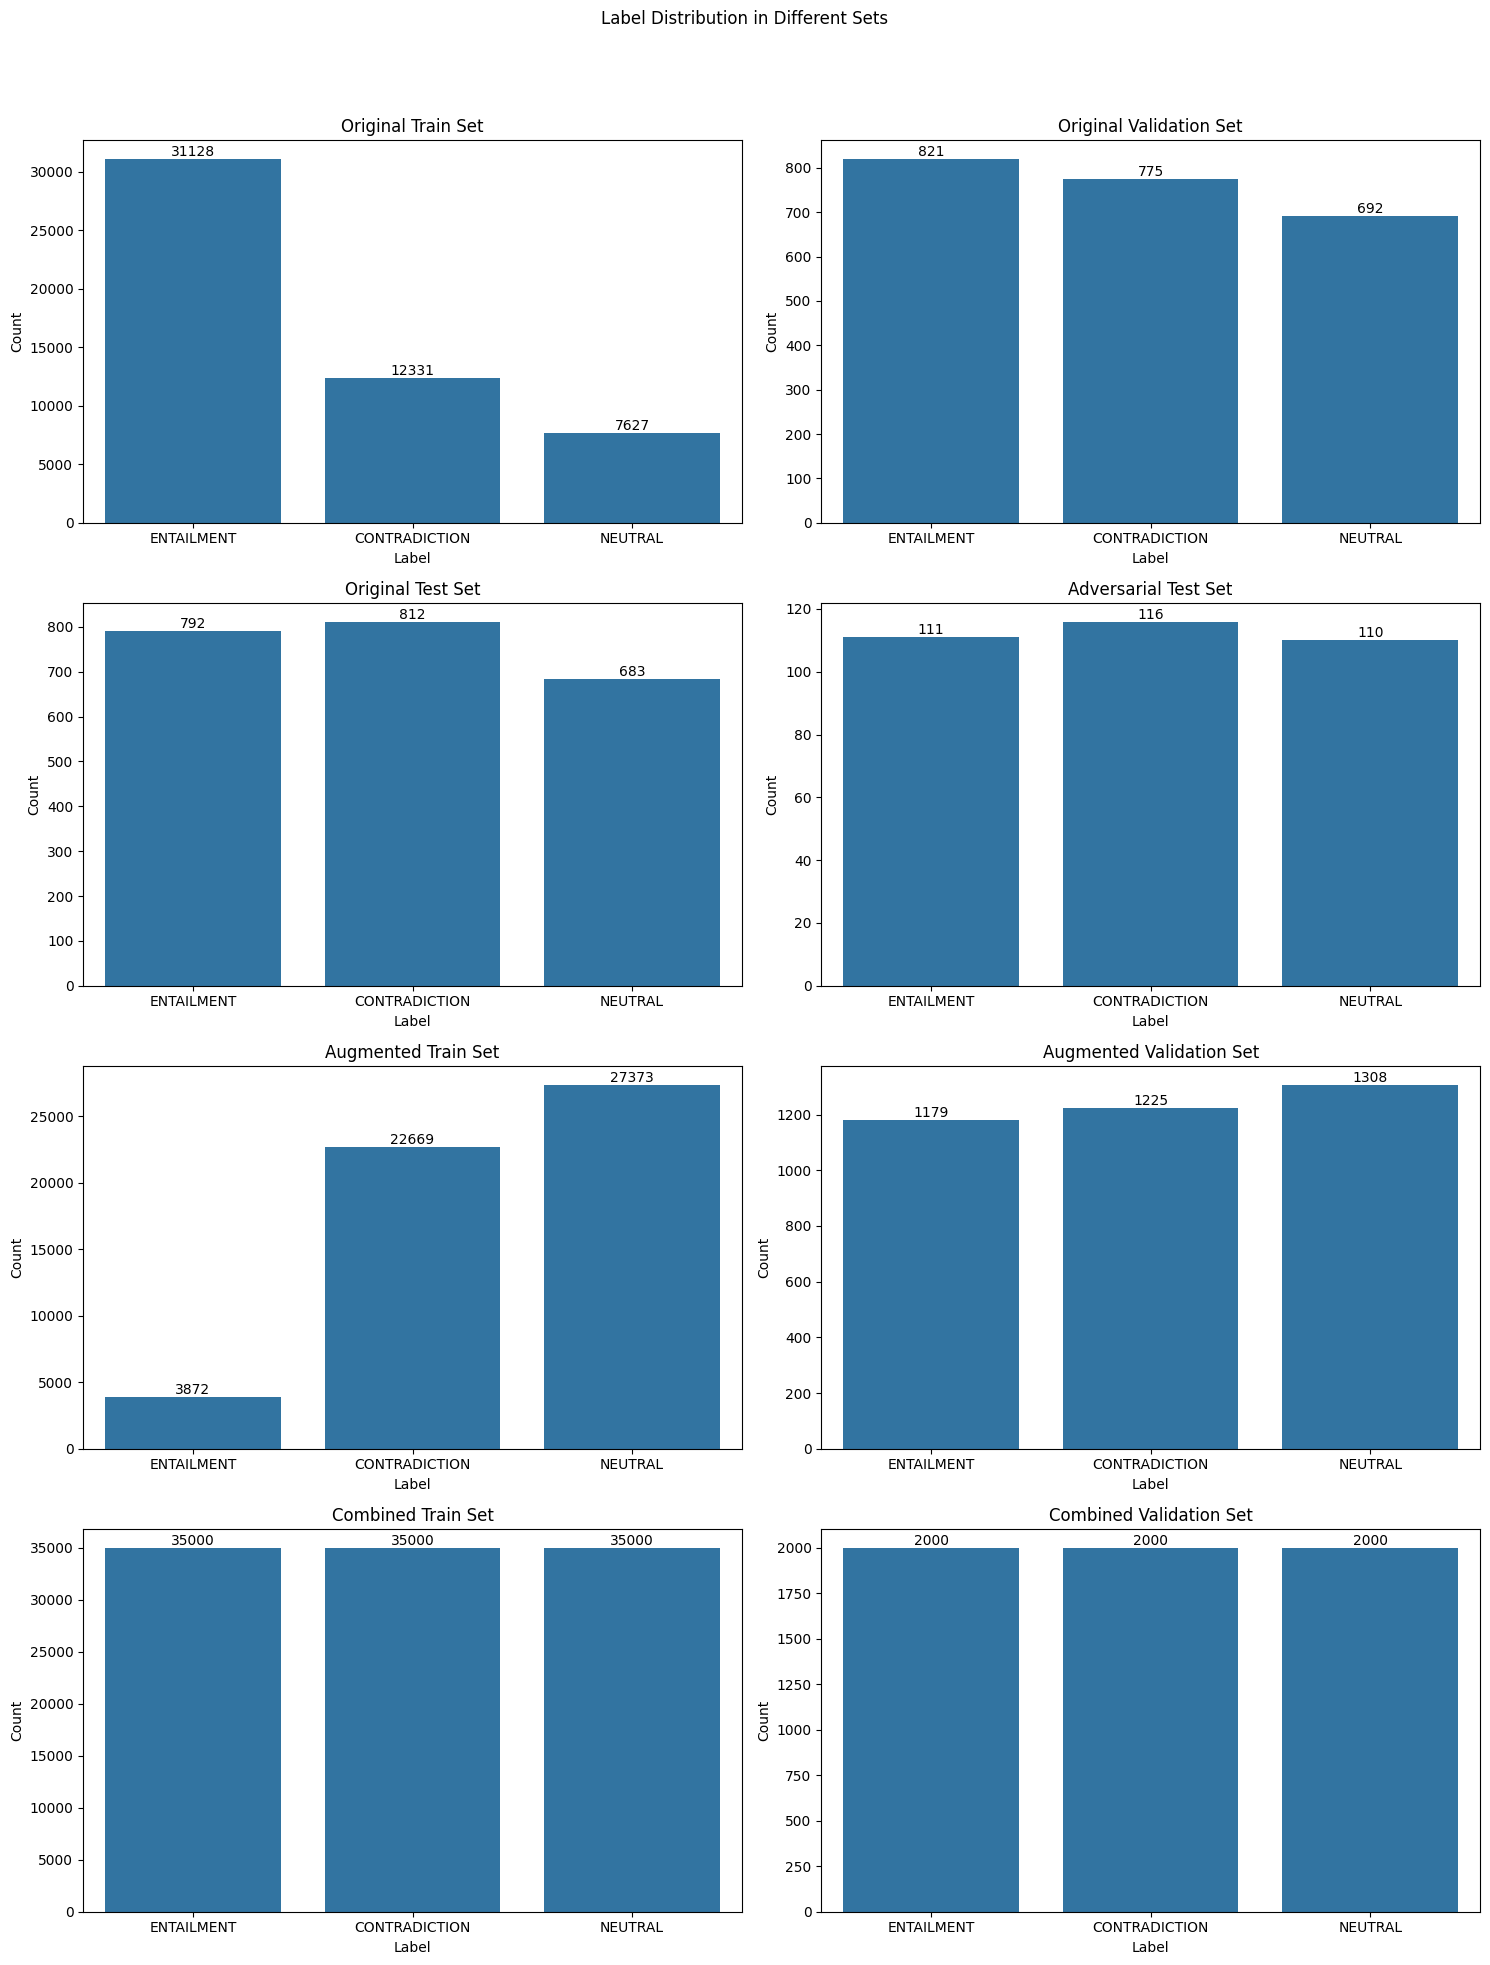

In [5]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

def save_plots():
    # Load the original dataset
    dataset = load_dataset("tommasobonomo/sem_augmented_fever_nli")
    
    # Load the adversarial test-set
    adversarial_test_data = load_dataset("iperbole/adversarial_fever_nli")['test']
    
    # Load the augmented train and validation datasets
    augmented_train_dataset_file = "augmented_train_data.jsonl"
    augmented_validation_dataset_file = "augmented_val_data.jsonl"
    augmented_train_labels = []
    augmented_validation_labels = []
    
    # Load the augmented train data
    with open(augmented_train_dataset_file, 'r', encoding='utf-8') as f:
        for line in f:
            augmented_train_labels.append(json.loads(line)['label'])
    
    # Load the augmented validation data
    with open(augmented_validation_dataset_file, 'r', encoding='utf-8') as f:
        for line in f:
            augmented_validation_labels.append(json.loads(line)['label'])
    
    # Extract the original dataset splits
    train_labels = dataset["train"]["label"]
    validation_labels = dataset["validation"]["label"]
    test_labels = dataset["test"]["label"]
    
    # Extract the adversarial test-set
    adversarial_test_labels = adversarial_test_data["label"]
    
    # Define the label names
    label_names = ["ENTAILMENT", "CONTRADICTION", "NEUTRAL"]
    
    # Combine original train set and augmented train set labels
    combined_train_labels = train_labels + augmented_train_labels
    combined_validation_labels = validation_labels + augmented_validation_labels
    
    # Create a function to prepare data for plotting
    def prepare_data(labels, label_names):
        counts = pd.Series(labels).value_counts().reindex(label_names, fill_value=0)
        df = pd.DataFrame({'Label': label_names, 'Count': counts})
        return df
    
    # Prepare data for all sets
    train_df = prepare_data(train_labels, label_names)
    validation_df = prepare_data(validation_labels, label_names)
    test_df = prepare_data(test_labels, label_names)
    adversarial_df = prepare_data(adversarial_test_labels, label_names)
    augmented_train_df = prepare_data(augmented_train_labels, label_names)
    augmented_validation_df = prepare_data(augmented_validation_labels, label_names)
    combined_train_df = prepare_data(combined_train_labels, label_names)
    combined_validation_df = prepare_data(combined_validation_labels, label_names)
    
    # Create the plot
    fig, axs = plt.subplots(4, 2, figsize=(15, 20))
    fig.suptitle("Label Distribution in Different Sets")
    
    # Function to plot a single subplot
    def plot_subplot(ax, data, title):
        sns.barplot(x='Label', y='Count', data=data, ax=ax)
        ax.set_title(title)
        ax.set_ylabel('Count')
        ax.set_xlabel('Label')
        
        # Add count
        for i, v in enumerate(data['Count']):
            ax.text(i, v, f"{v}", ha='center', va='bottom')
    
    # Plot all subplots
    plot_subplot(axs[0, 0], train_df, "Original Train Set")
    plot_subplot(axs[0, 1], validation_df, "Original Validation Set")
    plot_subplot(axs[1, 0], test_df, "Original Test Set")
    plot_subplot(axs[1, 1], adversarial_df, "Adversarial Test Set")
    plot_subplot(axs[2, 0], augmented_train_df, "Augmented Train Set")
    plot_subplot(axs[2, 1], augmented_validation_df, "Augmented Validation Set")
    plot_subplot(axs[3, 0], combined_train_df, "Combined Train Set")
    plot_subplot(axs[3, 1], combined_validation_df, "Combined Validation Set")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('plots.png')
    plt.show()

if __name__ == "__main__":
    save_plots()